Copied from keras github example.  
Visualization of the filters of VGG16, via gradient ascent in input space.  
This script can run on CPU in a few minutes. Results example: http://i.imgur.com/4nj4KjN.jpg


In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3945083874911913286, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9948139849965419217
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [0]:
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16, resnet50, inception_v3, densenet
from keras import backend as K

In [4]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.1.5
1.7.0


In [0]:
# dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

In [0]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.2
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.2

    # clip to [0, 1], and std range is 0.5+/-0.2
    # more contrast may the feature we will see be more obvious
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [9]:
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________________________________

In [0]:
# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [48]:
kept_filters = []
t0 = time.time()
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
print('Total processed in %ds' % (time.time() - t0))

Processing filter 0
Current loss value: 5.9036703
Current loss value: 16.272629
Current loss value: 34.032074
Current loss value: 55.8824
Current loss value: 76.34882
Current loss value: 102.51428
Current loss value: 121.871
Current loss value: 146.18472
Current loss value: 168.05676
Current loss value: 186.81805
Current loss value: 206.67247
Current loss value: 229.01888
Current loss value: 251.55447
Current loss value: 273.9231
Current loss value: 294.86496
Current loss value: 318.6144
Current loss value: 341.0583
Current loss value: 364.51755
Current loss value: 387.39743
Current loss value: 411.37238
Filter 0 processed in 1s
Processing filter 1
Current loss value: 0.042636797
Current loss value: 4.5178328
Current loss value: 12.147743
Current loss value: 23.273026
Current loss value: 33.6646
Current loss value: 49.82746
Current loss value: 70.68784
Current loss value: 96.02891
Current loss value: 122.10642
Current loss value: 148.18407
Current loss value: 178.49161
Current loss val

Current loss value: 856.89355
Current loss value: 925.86456
Current loss value: 994.32446
Current loss value: 1061.7725
Current loss value: 1131.3795
Current loss value: 1194.9891
Current loss value: 1260.5547
Current loss value: 1323.04
Current loss value: 1388.0089
Current loss value: 1450.2301
Filter 8 processed in 1s
Processing filter 9
Current loss value: 8.718916
Current loss value: 25.36415
Current loss value: 50.935753
Current loss value: 82.22822
Current loss value: 134.76129
Current loss value: 181.02377
Current loss value: 228.80396
Current loss value: 276.11667
Current loss value: 320.0699
Current loss value: 367.4652
Current loss value: 404.76117
Current loss value: 446.11987
Current loss value: 493.36307
Current loss value: 533.8578
Current loss value: 581.46063
Current loss value: 613.56995
Current loss value: 659.44385
Current loss value: 702.3523
Current loss value: 750.68536
Current loss value: 785.8683
Filter 9 processed in 1s
Processing filter 10
Current loss value:

Current loss value: 531.3035
Current loss value: 586.27405
Current loss value: 631.22986
Current loss value: 690.40515
Current loss value: 727.5331
Current loss value: 787.5473
Current loss value: 824.20557
Current loss value: 882.09534
Current loss value: 918.3521
Current loss value: 976.88153
Current loss value: 1018.0399
Current loss value: 1073.039
Current loss value: 1114.5968
Current loss value: 1170.7968
Current loss value: 1210.2421
Filter 18 processed in 1s
Processing filter 19
Current loss value: 0.0
Filter 19 processed in 0s
Processing filter 20
Current loss value: 19.235361
Current loss value: 23.609629
Current loss value: 56.081646
Current loss value: 84.83737
Current loss value: 114.17532
Current loss value: 140.58472
Current loss value: 166.79266
Current loss value: 201.14499
Current loss value: 232.68698
Current loss value: 267.38422
Current loss value: 301.88962
Current loss value: 338.54257
Current loss value: 371.3366
Current loss value: 404.0769
Current loss value: 

Current loss value: 177.84943
Current loss value: 211.5211
Current loss value: 248.57462
Current loss value: 281.7266
Current loss value: 321.70685
Current loss value: 359.33084
Current loss value: 395.4895
Current loss value: 433.79285
Current loss value: 471.48962
Current loss value: 511.45712
Current loss value: 550.2744
Current loss value: 586.6949
Current loss value: 624.2326
Current loss value: 659.866
Current loss value: 700.60254
Filter 30 processed in 1s
Processing filter 31
Current loss value: 1.2240276
Current loss value: 15.414283
Current loss value: 40.172737
Current loss value: 76.43622
Current loss value: 109.97425
Current loss value: 149.93729
Current loss value: 189.31549
Current loss value: 222.36708
Current loss value: 257.04446
Current loss value: 291.05188
Current loss value: 324.4073
Current loss value: 357.9088
Current loss value: 388.1229
Current loss value: 418.86005
Current loss value: 446.06638
Current loss value: 478.481
Current loss value: 509.17645
Current

Current loss value: 138.81271
Current loss value: 188.68596
Current loss value: 243.91719
Current loss value: 310.205
Current loss value: 381.94934
Current loss value: 461.66083
Current loss value: 540.88983
Current loss value: 622.1525
Current loss value: 707.4724
Current loss value: 792.68854
Current loss value: 872.2084
Current loss value: 949.18933
Current loss value: 1022.5112
Current loss value: 1097.6707
Current loss value: 1169.4462
Filter 40 processed in 1s
Processing filter 41
Current loss value: 0.019235184
Current loss value: 2.367484
Current loss value: 26.77339
Current loss value: 81.56858
Current loss value: 147.43782
Current loss value: 218.22089
Current loss value: 290.7677
Current loss value: 362.75726
Current loss value: 443.1819
Current loss value: 514.37585
Current loss value: 575.6856
Current loss value: 635.9672
Current loss value: 689.5399
Current loss value: 742.2782
Current loss value: 800.7773
Current loss value: 853.1282
Current loss value: 907.95996
Current

Current loss value: 745.73755
Current loss value: 810.886
Current loss value: 871.4948
Current loss value: 932.41943
Current loss value: 992.5425
Current loss value: 1048.8495
Current loss value: 1107.1025
Current loss value: 1164.3997
Current loss value: 1218.073
Current loss value: 1272.9275
Filter 48 processed in 1s
Processing filter 49
Current loss value: 0.26323703
Current loss value: 6.8165116
Current loss value: 22.313913
Current loss value: 65.993034
Current loss value: 126.817245
Current loss value: 188.91946
Current loss value: 265.22302
Current loss value: 339.59406
Current loss value: 421.13568
Current loss value: 490.6919
Current loss value: 569.6721
Current loss value: 638.05994
Current loss value: 710.4914
Current loss value: 781.1792
Current loss value: 851.6616
Current loss value: 919.1461
Current loss value: 987.2299
Current loss value: 1051.2504
Current loss value: 1118.1881
Current loss value: 1182.9998
Filter 49 processed in 1s
Processing filter 50
Current loss val

Current loss value: 402.91742
Current loss value: 463.30505
Current loss value: 522.4579
Current loss value: 578.00385
Current loss value: 637.2554
Current loss value: 696.63116
Current loss value: 758.0719
Current loss value: 818.7185
Current loss value: 878.7883
Current loss value: 934.426
Current loss value: 992.85803
Current loss value: 1056.1595
Current loss value: 1113.997
Current loss value: 1178.3512
Current loss value: 1239.9215
Filter 59 processed in 1s
Processing filter 60
Current loss value: 0.2204841
Current loss value: 0.18878026
Current loss value: 3.092619
Current loss value: 13.192228
Current loss value: 28.105722
Current loss value: 49.733288
Current loss value: 73.330894
Current loss value: 98.246994
Current loss value: 132.45198
Current loss value: 165.60025
Current loss value: 198.77272
Current loss value: 233.60359
Current loss value: 271.4483
Current loss value: 313.84735
Current loss value: 356.46054
Current loss value: 398.77484
Current loss value: 444.72113
Cu

Current loss value: 155.90994
Current loss value: 178.66193
Current loss value: 203.26498
Current loss value: 226.57033
Current loss value: 248.26862
Current loss value: 271.1751
Current loss value: 294.38208
Current loss value: 323.31708
Current loss value: 349.1099
Current loss value: 377.51266
Filter 70 processed in 1s
Processing filter 71
Current loss value: 0.0
Filter 71 processed in 0s
Processing filter 72
Current loss value: 0.05999058
Current loss value: 0.0
Filter 72 processed in 0s
Processing filter 73
Current loss value: 12.718538
Current loss value: 35.117176
Current loss value: 72.484604
Current loss value: 110.87504
Current loss value: 156.60208
Current loss value: 204.99562
Current loss value: 245.48178
Current loss value: 287.72955
Current loss value: 328.12646
Current loss value: 367.84982
Current loss value: 405.25412
Current loss value: 443.29678
Current loss value: 476.7491
Current loss value: 512.66
Current loss value: 545.5641
Current loss value: 582.3559
Current 

Current loss value: 298.98624
Current loss value: 372.3848
Current loss value: 439.68503
Current loss value: 508.36108
Current loss value: 575.6818
Current loss value: 651.0002
Current loss value: 705.9461
Current loss value: 779.19574
Current loss value: 846.7584
Current loss value: 912.9409
Current loss value: 978.21796
Current loss value: 1047.7908
Current loss value: 1105.9493
Current loss value: 1172.4484
Current loss value: 1231.9679
Filter 82 processed in 1s
Processing filter 83
Current loss value: 0.0
Filter 83 processed in 0s
Processing filter 84
Current loss value: 6.946942
Current loss value: 17.261293
Current loss value: 29.173763
Current loss value: 44.762417
Current loss value: 83.427216
Current loss value: 117.210915
Current loss value: 161.2667
Current loss value: 202.28586
Current loss value: 232.60757
Current loss value: 276.50073
Current loss value: 318.10257
Current loss value: 354.70752
Current loss value: 411.7514
Current loss value: 454.9085
Current loss value: 4

Current loss value: 230.50969
Current loss value: 295.50143
Current loss value: 359.32816
Current loss value: 425.74014
Current loss value: 488.7646
Current loss value: 549.87823
Current loss value: 607.1218
Current loss value: 666.85925
Current loss value: 722.11475
Current loss value: 777.02716
Current loss value: 832.49457
Current loss value: 886.8115
Current loss value: 938.0399
Current loss value: 994.6538
Current loss value: 1043.3312
Filter 93 processed in 1s
Processing filter 94
Current loss value: 0.0
Filter 94 processed in 0s
Processing filter 95
Current loss value: 43.06082
Current loss value: 82.82923
Current loss value: 128.48376
Current loss value: 169.75618
Current loss value: 209.48027
Current loss value: 242.78345
Current loss value: 280.0042
Current loss value: 317.39038
Current loss value: 350.11743
Current loss value: 386.45493
Current loss value: 419.71512
Current loss value: 453.31378
Current loss value: 485.79855
Current loss value: 518.8222
Current loss value: 5

Current loss value: 1.8754705
Current loss value: 8.43271
Current loss value: 29.190058
Current loss value: 53.03079
Current loss value: 81.548836
Current loss value: 109.88473
Current loss value: 139.78758
Current loss value: 172.80566
Current loss value: 204.50162
Current loss value: 235.63472
Current loss value: 265.8909
Current loss value: 295.0285
Current loss value: 322.28668
Current loss value: 351.1059
Current loss value: 379.02893
Current loss value: 407.43195
Current loss value: 435.89627
Current loss value: 465.0164
Current loss value: 491.98087
Current loss value: 519.4117
Filter 109 processed in 1s
Processing filter 110
Current loss value: 7.531494
Current loss value: 15.104876
Current loss value: 47.649788
Current loss value: 96.222435
Current loss value: 152.76181
Current loss value: 208.4873
Current loss value: 265.41138
Current loss value: 325.89175
Current loss value: 388.00925
Current loss value: 442.81076
Current loss value: 493.6867
Current loss value: 549.1152
Cur

Current loss value: 463.68414
Current loss value: 506.07333
Current loss value: 548.75586
Current loss value: 590.8284
Current loss value: 628.8889
Filter 118 processed in 1s
Processing filter 119
Current loss value: 1.0276209
Current loss value: 12.971468
Current loss value: 45.63507
Current loss value: 95.05983
Current loss value: 151.55458
Current loss value: 221.17606
Current loss value: 302.80466
Current loss value: 384.16498
Current loss value: 462.48865
Current loss value: 538.8529
Current loss value: 608.90283
Current loss value: 680.9387
Current loss value: 746.6406
Current loss value: 815.20355
Current loss value: 879.8943
Current loss value: 946.42444
Current loss value: 1013.49304
Current loss value: 1077.1967
Current loss value: 1139.8247
Current loss value: 1201.1467
Filter 119 processed in 1s
Processing filter 120
Current loss value: 0.026123926
Current loss value: 5.34303
Current loss value: 23.071514
Current loss value: 45.61696
Current loss value: 69.78044
Current los

Current loss value: 509.34387
Current loss value: 538.0882
Current loss value: 565.37213
Current loss value: 594.1899
Current loss value: 623.7062
Filter 127 processed in 1s
Processing filter 128
Current loss value: 11.580948
Current loss value: 33.416656
Current loss value: 67.40884
Current loss value: 111.72949
Current loss value: 174.58733
Current loss value: 246.78452
Current loss value: 317.69125
Current loss value: 393.6483
Current loss value: 466.85233
Current loss value: 543.3704
Current loss value: 615.6165
Current loss value: 687.2135
Current loss value: 759.2173
Current loss value: 826.47107
Current loss value: 898.4628
Current loss value: 960.1329
Current loss value: 1028.658
Current loss value: 1090.5685
Current loss value: 1155.6869
Current loss value: 1217.2571
Filter 128 processed in 1s
Processing filter 129
Current loss value: 0.051321533
Current loss value: 6.6117187
Current loss value: 37.52799
Current loss value: 87.49402
Current loss value: 142.76204
Current loss v

Current loss value: 684.21893
Current loss value: 738.7721
Current loss value: 789.67206
Current loss value: 846.4601
Current loss value: 899.2815
Filter 136 processed in 1s
Processing filter 137
Current loss value: 9.157774
Current loss value: 29.73352
Current loss value: 58.45952
Current loss value: 105.23675
Current loss value: 155.76642
Current loss value: 191.90839
Current loss value: 229.55878
Current loss value: 273.25656
Current loss value: 309.73138
Current loss value: 347.1637
Current loss value: 390.10898
Current loss value: 429.15903
Current loss value: 470.1374
Current loss value: 507.05713
Current loss value: 546.1803
Current loss value: 582.0002
Current loss value: 622.2709
Current loss value: 653.5768
Current loss value: 691.8719
Current loss value: 726.51276
Filter 137 processed in 1s
Processing filter 138
Current loss value: 17.92195
Current loss value: 146.2179
Current loss value: 292.6176
Current loss value: 423.07736
Current loss value: 528.1477
Current loss value:

Current loss value: 6.863452
Current loss value: 23.915876
Current loss value: 47.19618
Current loss value: 74.569954
Current loss value: 106.11062
Current loss value: 147.95924
Current loss value: 185.53328
Current loss value: 228.25725
Current loss value: 274.62967
Current loss value: 320.41513
Current loss value: 373.48578
Current loss value: 429.9872
Current loss value: 486.13794
Current loss value: 537.9183
Current loss value: 593.34485
Current loss value: 651.686
Current loss value: 715.65936
Current loss value: 784.01984
Current loss value: 852.499
Current loss value: 927.3586
Filter 146 processed in 1s
Processing filter 147
Current loss value: 0.0
Filter 147 processed in 0s
Processing filter 148
Current loss value: 0.04290834
Current loss value: 1.2714677
Current loss value: 2.2206082
Current loss value: 5.488179
Current loss value: 8.9519
Current loss value: 15.548921
Current loss value: 21.713
Current loss value: 31.4318
Current loss value: 40.012974
Current loss value: 52.35

Current loss value: 7.7166195
Current loss value: 20.182318
Current loss value: 35.5622
Current loss value: 52.203293
Current loss value: 76.225716
Current loss value: 99.217606
Current loss value: 131.12672
Current loss value: 163.41731
Current loss value: 197.1938
Current loss value: 237.30176
Current loss value: 279.9143
Current loss value: 319.6637
Current loss value: 360.9604
Current loss value: 403.4419
Current loss value: 451.16174
Current loss value: 493.00555
Current loss value: 538.29254
Current loss value: 583.5203
Current loss value: 624.40424
Current loss value: 662.4582
Filter 155 processed in 1s
Processing filter 156
Current loss value: 0.0
Filter 156 processed in 0s
Processing filter 157
Current loss value: 4.5390396
Current loss value: 34.303387
Current loss value: 104.28369
Current loss value: 184.19058
Current loss value: 269.22064
Current loss value: 348.6835
Current loss value: 425.97238
Current loss value: 500.137
Current loss value: 577.0778
Current loss value: 6

Current loss value: 95.06788
Current loss value: 121.76208
Current loss value: 153.58342
Current loss value: 181.34705
Current loss value: 215.40793
Current loss value: 251.33752
Current loss value: 285.558
Current loss value: 323.12988
Current loss value: 357.99274
Current loss value: 399.71924
Current loss value: 437.69
Current loss value: 476.4909
Current loss value: 511.78827
Current loss value: 554.7299
Current loss value: 589.75385
Filter 165 processed in 1s
Processing filter 166
Current loss value: 0.0
Filter 166 processed in 0s
Processing filter 167
Current loss value: 23.355461
Current loss value: 42.736065
Current loss value: 86.245636
Current loss value: 122.788994
Current loss value: 160.02965
Current loss value: 195.09694
Current loss value: 229.95996
Current loss value: 261.5059
Current loss value: 293.5249
Current loss value: 329.1521
Current loss value: 362.5051
Current loss value: 390.55862
Current loss value: 421.47147
Current loss value: 452.91812
Current loss value:

Filter 175 processed in 1s
Processing filter 176
Current loss value: 0.117793314
Current loss value: 8.834304
Current loss value: 44.69434
Current loss value: 98.72101
Current loss value: 150.93933
Current loss value: 205.78546
Current loss value: 261.09006
Current loss value: 315.84866
Current loss value: 369.99808
Current loss value: 418.25934
Current loss value: 465.23746
Current loss value: 516.7407
Current loss value: 565.77435
Current loss value: 615.554
Current loss value: 665.9234
Current loss value: 713.0113
Current loss value: 760.4909
Current loss value: 809.383
Current loss value: 861.48535
Current loss value: 912.39014
Filter 176 processed in 1s
Processing filter 177
Current loss value: 3.8733063
Current loss value: 7.0338707
Current loss value: 13.230961
Current loss value: 21.973196
Current loss value: 34.62773
Current loss value: 57.267128
Current loss value: 85.71621
Current loss value: 114.22672
Current loss value: 141.23792
Current loss value: 171.8108
Current loss v

Current loss value: 347.43243
Current loss value: 393.72513
Current loss value: 436.6853
Current loss value: 481.2565
Current loss value: 523.1344
Current loss value: 566.6265
Current loss value: 606.09534
Current loss value: 646.13885
Current loss value: 687.4277
Current loss value: 726.89526
Filter 186 processed in 1s
Processing filter 187
Current loss value: 7.0926175
Current loss value: 47.956383
Current loss value: 139.27141
Current loss value: 231.41545
Current loss value: 327.24728
Current loss value: 411.64648
Current loss value: 490.1017
Current loss value: 568.54395
Current loss value: 647.0459
Current loss value: 721.0228
Current loss value: 797.5205
Current loss value: 869.9482
Current loss value: 940.8424
Current loss value: 1010.7936
Current loss value: 1084.3853
Current loss value: 1155.8234
Current loss value: 1229.0596
Current loss value: 1301.9172
Current loss value: 1373.6254
Current loss value: 1443.5635
Filter 187 processed in 1s
Processing filter 188
Current loss 

In [0]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

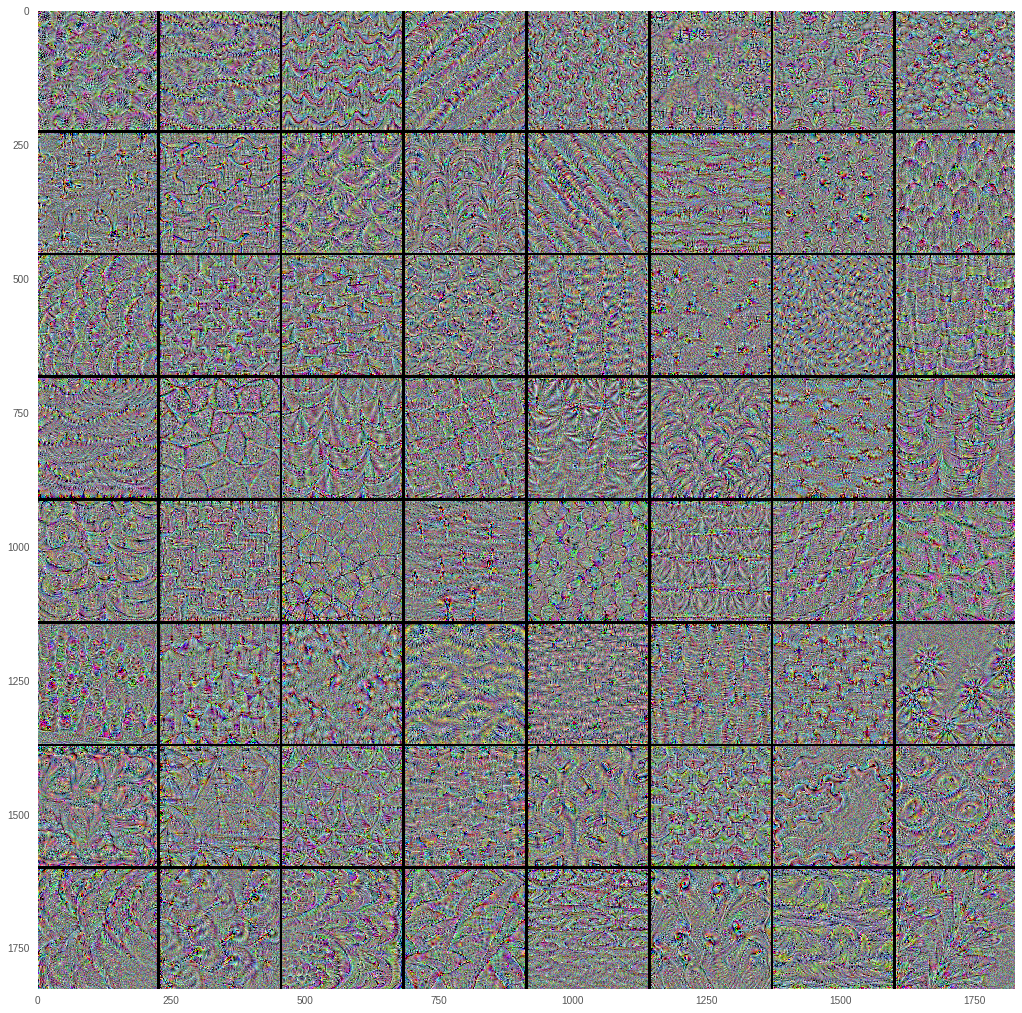

In [50]:
fig = plt.figure(figsize=(18,18))
ax = fig.gca()
ax.grid(False)
plt.imshow(stitched_filters)
plt.show()

See what the cnn imagine what a certain class may be.

In [56]:
model = vgg16.VGG16(weights='imagenet', include_top=True)
print('Model loaded.')
model.summary()

553476096/553467096 [==============================] - 11s 0us/step
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.2
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.3

    # clip to [0, 1], and std range is 0.5+/-0.2
    # thus the feature we will see could be more obvious
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [117]:
# this is the placeholder for the input images
input_img = model.input

output_index = 765  # rocking_chair
loss = K.mean(model.output[:, output_index])

start_time = time.time()
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

if loss_value > 0:
    img = deprocess_image(input_img_data[0])

end_time = time.time()
print('Total processed in %ds' % (end_time - start_time))

Current loss value: 0.0003135332
Current loss value: 0.0010565368
Current loss value: 0.0013813837
Current loss value: 0.0043826937
Current loss value: 0.0012333859
Current loss value: 0.051250424
Current loss value: 0.542202
Current loss value: 0.3145095
Current loss value: 0.9173867
Current loss value: 0.9711676
Current loss value: 0.9969901
Current loss value: 0.9996176
Current loss value: 0.9999856
Current loss value: 0.9999882
Current loss value: 0.9999895
Current loss value: 0.9999906
Current loss value: 0.99999154
Current loss value: 0.99999213
Current loss value: 0.9999927
Current loss value: 0.9999933
Total processed in 2s


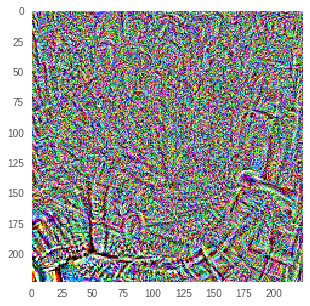

In [118]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.grid(False)
plt.imshow(img)
plt.show()

In [119]:
p_img = model.predict(img[None,:], verbose=1)

1/1 [==============================] - 0s 50ms/step


In [120]:
p_img.argmax()

765

In [101]:
output_index = 123  # spiny_lobster
loss = K.mean(model.output[:, output_index])

start_time = time.time()
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

if loss_value > 0:
    img = deprocess_image(input_img_data[0])

end_time = time.time()
print('Total processed in %ds' % (end_time - start_time))

Current loss value: 7.059283e-05
Current loss value: 0.00010403502
Current loss value: 0.0001686439
Current loss value: 0.00032112005
Current loss value: 0.0008231973
Current loss value: 0.002522584
Current loss value: 0.010134072
Current loss value: 0.06584632
Current loss value: 0.017225865
Current loss value: 0.39790916
Current loss value: 0.46858275
Current loss value: 0.91456103
Current loss value: 0.8678173
Current loss value: 0.9886718
Current loss value: 0.9926005
Current loss value: 0.9989453
Current loss value: 0.9999144
Current loss value: 0.9999629
Current loss value: 0.9999709
Current loss value: 0.9999758
Total processed in 2s


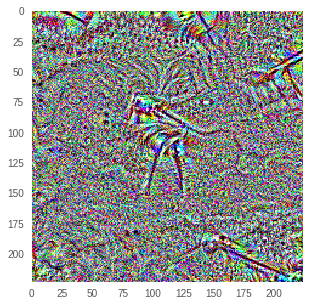

In [102]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.grid(False)
plt.imshow(img)
plt.show()

In [79]:
p_img = model.predict(img[None,:], verbose=1)

1/1 [==============================] - 0s 45ms/step


In [80]:
p_img.argmax()

123

In [125]:
output_index = 854  # theater_curtain
loss = K.mean(model.output[:, output_index])

start_time = time.time()
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
g_values = []
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    g_values.append(grads_value.max())

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

if loss_value > 0:
    img = deprocess_image(input_img_data[0])

end_time = time.time()
print('Total processed in %ds' % (end_time - start_time))

Current loss value: 9.989805e-05
Current loss value: 0.00017034411
Current loss value: 0.00033547438
Current loss value: 0.00066160434
Current loss value: 0.0010489383
Current loss value: 0.0012788556
Current loss value: 0.0023013547
Current loss value: 0.0069540828
Current loss value: 0.022916423
Current loss value: 0.23224424
Current loss value: 0.78272516
Current loss value: 0.9441113
Current loss value: 0.977505
Current loss value: 0.9981681
Current loss value: 0.9998099
Current loss value: 0.99997044
Current loss value: 0.99997675
Current loss value: 0.99998045
Current loss value: 0.9999827
Current loss value: 0.9999846
Total processed in 2s


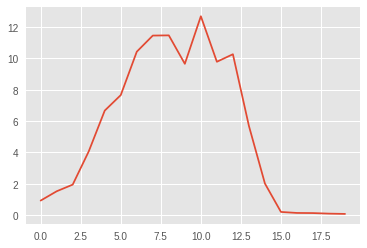

In [126]:
plt.plot(range(20), g_values)

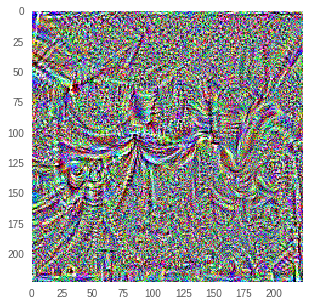

In [127]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.grid(False)
plt.imshow(img)
plt.show()

In [128]:
p_img = model.predict(img[None,:], verbose=1)

1/1 [==============================] - 0s 43ms/step


In [129]:
p_img.argmax()

854

See how other cnns perform

In [131]:
model = resnet50.ResNet50(weights='imagenet', include_top=True)
print('Model loaded.')
model.summary()

102866944/102853048 [==============================] - 2s 0us/step
Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________

In [138]:
# this is the placeholder for the input images
input_img = model.input

output_index = 854  # theater_curtain
loss = K.mean(model.output[:, output_index])

start_time = time.time()
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(15):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

if loss_value > 0:
    img = deprocess_image(input_img_data[0])

end_time = time.time()
print('Total processed in %ds' % (end_time - start_time))

Current loss value: 4.568078e-05
Current loss value: 0.00016156987
Current loss value: 0.00052652985
Current loss value: 0.00065829343
Current loss value: 0.0008111192
Current loss value: 0.0041363724
Current loss value: 0.09333205
Current loss value: 0.20688435
Current loss value: 0.9478595
Current loss value: 0.9889213
Current loss value: 0.9995103
Current loss value: 0.9999105
Current loss value: 0.9999989
Current loss value: 0.9999989
Current loss value: 0.9999989
Total processed in 5s


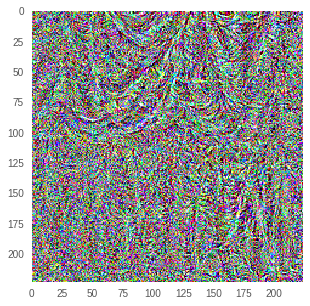

In [139]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.grid(False)
plt.imshow(img)
plt.show()

In [140]:
p_img = model.predict(img[None,:], verbose=1)

1/1 [==============================] - 2s 2s/step


In [141]:
p_img.argmax()

854

In [143]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=True)
print('Model loaded.')
model.summary()

96124928/96112376 [==============================] - 14s 0us/step


Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________________

In [145]:
# this is the placeholder for the input images
input_img = model.input

output_index = 854  # theater_curtain
loss = K.mean(model.output[:, output_index])

start_time = time.time()
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(15):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

if loss_value > 0:
    img = deprocess_image(input_img_data[0])

end_time = time.time()
print('Total processed in %ds' % (end_time - start_time))

Current loss value: 0.0
Total processed in 9s
